# Machine Learning Models for Credit Card Fraud Detection
In the previous version, Exploratory Data Analysis was conducted and after that Base Model was created. This notebook is focus on developing the models with various techniques such as Synthetic Minority Oversampling Technique (SMOTE) and Random Undersampling as the distribution of the class is not balanced because there are only 0.17% of the fraud cases compare to 99.83% of the normal transaction.

To access the credit card dataset. The dataset can be downloaded from https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#loading the dataset
df=pd.read_csv("creditcard.csv")

In [3]:
#Displaying first five rows of the dataset
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Feature Engineering
All the variables except Time and amount are transformed using Principal Component Analysis Technique.Therefore, it is vital for us to scale the Time and amount variable.To make our dataset uniform, various steps in feature engineering is conducted which are as follows:

1. The variables amount and time are scaled using Standard Scalar and stored in the new variables named scaled_amount and scaled_time
2. The original variables amount and time is dropped from the dataset to reduce ambuguity
3. The scaled_amount and scaled_time variable is added in the dataset

In [4]:
# Since most of our data has already been scaled we should scale the columns that are left to scale i.e Amount and Time
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()

scaled_amount=sc.fit_transform(df['Amount'].values.reshape(-1,1))
scaled_time=sc.fit_transform(df['Time'].values.reshape(-1,1))

In [5]:
#Drop Time and Amount Variable
df.drop(['Time','Amount'], axis=1, inplace=True)

In [6]:
#insert scaled amount and time variable
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

In [7]:
# Amount and Time are Scaled in this new data
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# -------------------------------------- Development ----------------------------------------------
The objective of this project is to accurately detect fraud cases. Therefore, we will use recall evaluation matrix that will help us to determine how accurate our model is detecting the fraud cases. We will try to reduce Type II error in the models throughout this notebook.

For models, 80% of the data is used for the training purpose while 20% of the data is used to test the model

Target Variable:
1. 0 represent No fraud case i.e. normal payment
2. 1 represent fraud case 

## Development Stage #1:
In this stage, models are run on original dataset without using any technique to detect the fraud cases.

In [8]:
#Defining x and y variable
X = df.drop('Class', axis=1)
y = df['Class']

#Create Training Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [9]:
#we can use multiple model in the for loop
for name,method in [('Logistic Regression',LogisticRegression(random_state=10)),('Decision Tree', DecisionTreeClassifier(random_state=10)),('Random Forest Classifier',RandomForestClassifier(random_state=10))]: 
    method.fit(X_train,y_train)
    predict = method.predict(X_test)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))


Estimator: Logistic Regression
[[56849    17]
 [   38    58]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.77      0.60      0.68        96

    accuracy                           1.00     56962
   macro avg       0.89      0.80      0.84     56962
weighted avg       1.00      1.00      1.00     56962


Estimator: Decision Tree
[[56832    34]
 [   25    71]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.68      0.74      0.71        96

    accuracy                           1.00     56962
   macro avg       0.84      0.87      0.85     56962
weighted avg       1.00      1.00      1.00     56962


Estimator: Random Forest Classifier
[[56855    11]
 [   29    67]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.86      0.70      0.77      

##### Summary
1. Logistic regression misclassifies 38 fraud cases whereas Decision Tree and Random Forest classifier misclassifies 25 and 29 fraud cases respectively

##### Insights from Development Stage #1:
1. Decision Tree Classifier gives better prediction compare to other two models

## Development Stage #2: SMOTE
To solve the problem of imbalanced class, one of the method is Synthetic Minority Oversampling Technique (SMOTE) that is conducted in this development stage. SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. 

SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

In [11]:
#create x and y variable
X = df.drop('Class', axis=1)
y = df['Class']

#Create Training Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [12]:
#SMOTE
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_sample(X_train,y_train)

#Class Balance - Test Data
print('SMOTE - Class Split')
num_zeros = (y_train_smt == 0).sum()
num_ones = (y_train_smt == 1).sum()
print('Class 0 -',  num_zeros)
print('Class 1 -',  num_ones)

Using TensorFlow backend.


SMOTE - Class Split
Class 0 - 227449
Class 1 - 227449


After applying SMOTE, distribution of class is balanced so that model would not be biased towards majority class.

Note: Considering that there are lots of data points, we are running only two models; first is logistic regression and second is decision tree. Random forest runs multiple decision trees, so running random forest classifier with SMOTE would be a costly affair. Also, from the first development stage, it was identified that decision tree and logistic regression are better compare to random forest classifier

#### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train_smt,y_train_smt)
y_pred = logreg.predict(X_test)


print('\n', confusion_matrix(y_test,y_pred))  
print('\n',classification_report(y_test,y_pred)) 


 [[55574  1292]
 [   10    86]]

               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56866
           1       0.06      0.90      0.12        96

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



#### Decision Tree Classifier

In [14]:
from sklearn.tree import DecisionTreeClassifier

logreg = DecisionTreeClassifier(random_state=10)
logreg.fit(x_train_smt,y_train_smt)
y_pred = logreg.predict(X_test)


print('\n', confusion_matrix(y_test,y_pred))  
print('\n',classification_report(y_test,y_pred)) 


 [[56754   112]
 [   21    75]]

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56866
           1       0.40      0.78      0.53        96

    accuracy                           1.00     56962
   macro avg       0.70      0.89      0.76     56962
weighted avg       1.00      1.00      1.00     56962



#### Summary
1. The result of Logistic Regression model has improved from previous stage and it only misclassifies 10 fraud cases compare to 38 fraud cases
2. The result of decision tree classifier has slightly improved from previous stage and it misclassifies 21 fraud cases compare to 25 fraud cases

#### Insight from development stage #2
1. The model gives unbiased result because of using SMOTE technique and it gives better performance in terms of recall i.e. misclassification of the fraud cases.
2. Logistic regression provides faster and accurate result compare to decision tree algorithm

## Development Stage #3: Random Under Sampling
The other technique that is used to overcome the problem of imbalanced dataset is random under sampling. In this technique, majority class is undersampled to match the length of minority class

In [16]:
#create x and y variable
X = df.drop('Class', axis=1)
y = df['Class']

#Create Training Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [17]:
#Downsample majority
from sklearn.utils import resample
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
NoFraud = X[X.Class==0]
Fraud = X[X.Class==1]

#Downsample Majority
NoFraud_downsampled = resample(NoFraud,
                                replace = False, # sample without replacement
                                n_samples = len(Fraud), # match minority n
                                random_state = 100) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([NoFraud_downsampled, Fraud])

#Undersampling - Test Data
print('Undersampling - Class Split')
num_zeros = (downsampled.Class == 0).sum()
num_ones = (downsampled.Class == 1).sum()
print('Class 0 -',  num_zeros)
print('Class 1 -',  num_ones)

Undersampling - Class Split
Class 0 - 396
Class 1 - 396


In [18]:
#create x and y variable
X = downsampled.drop('Class', axis=1)
y = downsampled['Class']

#Create Training Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [19]:
# three models are run
for name,method in [('Logistic Regression',LogisticRegression(random_state=10)),('Decision Tree', DecisionTreeClassifier(random_state=10)),('Random Forest Classifier',RandomForestClassifier(random_state=10))]: 
    method.fit(X_train,y_train)
    predict = method.predict(X_test)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))


Estimator: Logistic Regression
[[74  1]
 [ 6 78]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.95        75
           1       0.99      0.93      0.96        84

    accuracy                           0.96       159
   macro avg       0.96      0.96      0.96       159
weighted avg       0.96      0.96      0.96       159


Estimator: Decision Tree
[[66  9]
 [ 6 78]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        75
           1       0.90      0.93      0.91        84

    accuracy                           0.91       159
   macro avg       0.91      0.90      0.91       159
weighted avg       0.91      0.91      0.91       159


Estimator: Random Forest Classifier
[[72  3]
 [ 6 78]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        75
           1       0.96      0.93      0.95        84

    accuracy                  

#### Summary
1. All the models misclassified 6 fraud cases. So, Type II error is same for all the models and hence recall is 93%
2. To compare, lets see Type 1 error i.e. logistic regression misclassify 1 no fraud case whereas decision tree and random forest misclassified 9 and 3 no fraud cases respectively.

#### Insights from development stage #3:
1. Logistic regression performs better compare to decision tree and random forest classifier in terms of both fraud and non fraud cases

# Checking for Overfitting and Underfitting
It is important for the machine learning algorithm to be good fit. To evaluate that, learning curve will be plotted to ensure we have less training and validation(test) error. This will also help us to select the best fit model.

In [20]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=10))])
pipeline.insert(0,pipe_logreg)

pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('clf', DecisionTreeClassifier(random_state=10))])
pipeline.insert(1,pipe_dt)

pipe_rdf = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(random_state=10))])
pipeline.insert(2,pipe_rdf)



# Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l1', 'l2']}
modelpara.insert(0,param_gridlogreg)


max_depth = range(1,100)
param_griddt = {'clf__criterion':['gini','entropy'],
                'clf__max_depth':max_depth}
modelpara.insert(1,param_griddt)

param_gridrdf = {
            'clf__n_estimators': [100,150,200],
            'clf__max_features': ['auto', 'log2', 'sqrt'],
            'clf__bootstrap': [True, False]}
modelpara.insert(2,param_gridrdf)

In [21]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=X_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',
                                                            n_jobs=1,random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Logisistic Regression - Learning Curve


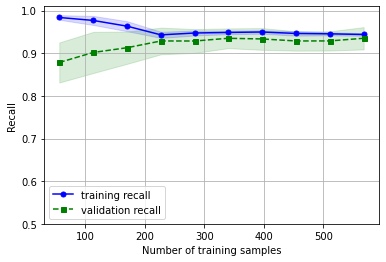

Decision Tree - Learning Curve


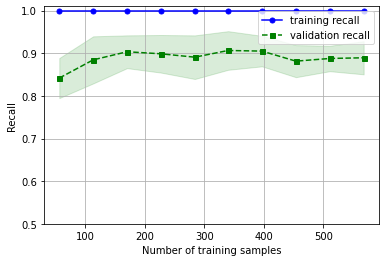


Random Forest - Learning Curve


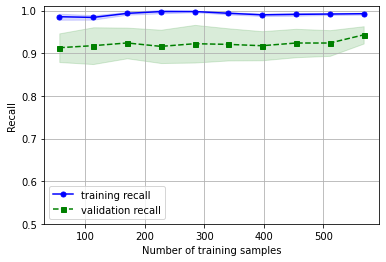

In [22]:
#Plot Learning Curve
print('Logisistic Regression - Learning Curve')
plot_learning_curves(pipe_logreg)
print('Decision Tree - Learning Curve')
plot_learning_curves(pipe_dt)
print('\nRandom Forest - Learning Curve')
plot_learning_curves(pipe_rdf)

#### Insights from learning curve
1. For logistic regression, at first training recall is high and validation recall is low but as the datapoints get trained the model recall rate becomes almost same for both test and training data. This indicate that model is a good fit for this dataset
2. For decision tree, training recall remains constant regardless of the increase in training data whereas validation recall is low at first then it increases and starts to fluctuate and then becomes constant.This indicates that this model is little bit overfitting the dataset
3. For 

# Optimized model and AUC-ROC Curve
Logistic Regression model is selected based on its performance. The optimized model is run to improve the performance using Grid search cross validation that will choose the best hyperparamters to provide the accurate result. Moreover, AUC-ROC curve (Area Under the Curve – Receiver Operating Characteristics) is also an important metric that will help to know the capacity of the model on how well it distinguishes the classes No fraud and fraud. 

In [23]:
#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(random_state=10))])
pipeline.insert(0,pipe_logreg)

# Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l1', 'l2']}
modelpara.insert(0,param_gridlogreg)

In [24]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=1, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(X_train, y_train)
    model = gs_clf.best_estimator_
    
    #Nested CV
    scoreACC = cross_val_score(gs_clf, X, y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, X, y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, X, y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(X_test)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['No Fraud','Fraud']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreRM),np.std(scoreRM)))
    print('\n')
    
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


Optimized Model

Model Name: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=10, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Best Parameters: {'clf__C': 1, 'clf__penalty': 'l1'}

 [[73  2]
 [ 6 78]]

               precision    recall  f1-score   support

    No Fraud       0.92      0.97      0.95        75
       Fraud       0.97      0.93      0.95        84

    accuracy                           0.95       159
   macro avg       0.95      0.95      0.95       159
weighted avg       0.95      0.95      0.95       159


NestedCV Accuracy(weighted) :0.93 +/-0.01 
NestedCV Precision(weighted) :0.94 +/-0.01 
NestedCV Recall(weighted) :0.93 +/-0.01 


ROC Curve


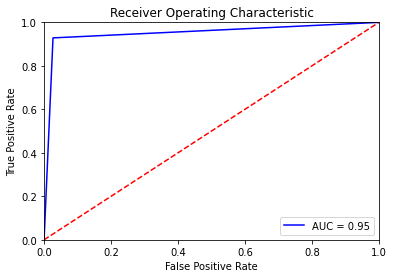

In [25]:
#Run Models
for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

#### Summary
1. Optimized model select the best hyperparamters and only misclassify 6 fraud cases and 2 non fraud cases. Overall, model is performing good and it is not biased towards any class because we have already undersampled the dataset
2. AUC- ROC curve represents that our model is able to differentiate No fraud and fraud cases 95% of the time

### ---------------------------------------------------------   End of Development   ---------------------------------------------------------------

# Insights
1. The result of the development stage 1 is not useful as our dataset is not balanced but still if someone wants to use the raw dataset then decision tree classifier is performing better than other models
2. For development stage 2, Synthetic Minority Oversampling technique is used that is giving us unbiased result and it solved the problem of overfitting by random oversampling, therefore we have used SMOTE instead of random oversampling. Logistic regression performs better than decision tree and misclassify only 10 fraud cases
3. For development stage 3, random undersampling is used to balance the distribution of the class. Logistic regression performs better than other models in terms of both fraud and no fraud cases
4. Learning curve is plotted for different models to identify underfitting and overfitting of the model.Logistic Regression is identified as good fit model because training and validation recall is almost same
5. With the help of grid search cross validation, optimized model is selected based on hyperparameter tuning. However, the performance of the model did not improve from the previous model
6. With the help of AUC-ROC curve, I can say that we are successful in detecting fraud and no fraud cases 95% of the time

# Conclusion
I would recommend to use logistic regression model because it is accurate and less time consuming. If you have more time to perform the model then I would say use the SMOTE technique (Development Stage 2) and if there is a time constraint then I would say go for random undersampling (Development Stage 3) to detect fraud and no fraud cases. Thus, in this notebook we have successully detect most of the fraud and no fraud cases with 90% or more recall score.